# Gap up short trade

In [1]:
from IPython.display import Image
from pandas.tseries.offsets import BDay
import os
# Import config file to get database info
import configparser

# Use shutil to copy charts to pattern directory
import shutil
import datetime
import time
import math
import statistics
import numpy as np
import pandas as pd
import pytz
import sqlalchemy

# Show pretty progress bars
from tqdm import tqdm

#Needed for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Choose a seaborn palette
sns.set_palette("pastel")

# Various customizations for matplotlib and seaborn to get pretty plots
small_font_size = 12
medium_font_size = 14
large_font_size = 16

plt.rc('font', size=medium_font_size)          # controls default text sizes
plt.rc('axes', titlesize=medium_font_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_font_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=medium_font_size)    # legend fontsize
plt.rc('figure', titlesize=large_font_size)   # fontsize of the figure title

# Set matplotlib to always use the Inter font
plt.rcParams['font.family'] = "Inter"

In [2]:
# Load configuration
config = configparser.ConfigParser()
config.read("../config/config.cnf")

host = config['postgresql']['host']
user = config['postgresql']['user']
passwd = config['postgresql']['passwd']
db = config['postgresql']['db']

## Helper functions and variables

In [3]:
# Percentile list used below for analysis
percentiles = [.10, .20, .30, .40, .50, .60, .70, .80, .90]

# Optionally set a pattern here
pattern_name = ""

### Database connection(s)

In [4]:
# Connect to database
engine = sqlalchemy.create_engine(f"postgresql+psycopg2://{user}:{passwd}@{host}:5432/{db}", 
                                       connect_args={'sslmode': 'require'}, 
                                       echo=False)

## Read data from source

In [5]:
# Read db table containing patterns
source_df = pd.read_sql('SELECT * FROM pt_output;', con=engine)

Show some basic info about the data set:

In [6]:

print(f"Rows in data set: {len(source_df.axes[0])}")

print("Columns:")
for item in source_df.columns:
    print(item)


Rows in data set: 2289
Columns:
date
symbol
pattern
secondary_pattern
chart_nr
mkt_cap
shs_float
comment
news_date
news_headline
news_link
dilution_filing
dilution_filing_date
dilution_filing_file_number
dilution_filing_link
split_history
sector
industry
country
chart_name_eod
chart_name_1m
risk_level
support_level
gap-up_short_second_push
news_classifier
chart_name_manual
traded_profit
traded_loss
short_at_open
o
h
l
c
v
o-1
h-1
l-1
c-1
v-1
close_sma_10
premkt_04:00:00_vwap
premkt_04:00:00_volume_ma
premkt_04:00:00_09:29:00_volume
premkt_04:00:00_09:29:00_volume_max
premkt_04:00:00_09:29:00_volume_min
premkt_04:00:00_09:29:00_volume_vs_shs_float
premkt_04:00:00_09:29:00_volume_vs_total_volume
premkt_04:00:00_09:29:00_volume_mean_over_first_15_candles
premkt_04:00:00_09:29:00_volume_mean_over_last_15_candles
premkt_04:00:00_09:29:00_dollar_volume
premkt_04:00:00_09:29:00_dollar_volume_vs_mkt_cap
premkt_04:00:00_09:29:00_high
premkt_04:00:00_09:29:00_high_t
premkt_04:00:00_09:29:00_low


## Data cleanup

In [7]:
# Make sure that pandas knows that there's a date
# But don't use it as index because there the same date 
# can appear multiple times
source_df["date"] = pd.to_datetime(source_df["date"])
# Sort by date
source_df.sort_values(by=['date'])

# Let's remove all rows which do not contain a pattern
# Not in this case, we let the data "guide us"
#df.dropna(subset=['pattern'])
#print(f"Rows in data set after removing rows with empty patterns: {df.count(axis='rows')[0]}")

# Some basic hygiene
source_df["sector"] = source_df["sector"].str.replace("Health Care", "Healthcare")

## Select data from source_df

In [15]:
# The high should be before the low during 9:30 am to 12:00 am, only select matching rows
select_df = source_df[(source_df['morning_09:30:00_11:59:00_high_t'] < source_df['morning_09:30:00_11:59:00_low_t'])]

# Make copy to avoid "A value is trying to be set on a copy of a slice from a DataFrame."
df = select_df.copy()

# We have to further narrow down our search because some 1-minute data has been adjusted for splits while eod data has not
# This results in some stocks seemingly shooting up, e.g., 8200%
# It makes sense to, e.g., leave out stocks gapping up more than 200% since we rarely see this
# df = df[(df["pattern"] == 'gap-up_short') &  (df["date"] > "2020-01-01") &  (df["o_pct"] < 2) & (df['shs_float'] < 50) ]

print(f"Number of rows in selection: {len(df.axes[0])}")

Number of rows in selection: 1339


In [16]:
# Calculate percent change from high to low in a new df column
df['morning_09:30:00_11:59:00_high_vs_low_pct'] = df['morning_09:30:00_11:59:00_low'] / df['morning_09:30:00_11:59:00_high'] - 1

### How to find the right gap-up level

We care about the difference between the high and the low between 9:30 am and 12 pm, because that's where we would like to short stocks. A basic premise of the strategy is that a company will publish news to boost their stock, making it gap up. But which gap-up level gives us the best chance of a successful trade? Let's plot the correlation between 'morning_09:30:00_11:59:00_high_vs_low_pct' and 'o_pct'. Before that, let's look at them individually, starting with 'o_pct' (how much the stock gaps up from the previous close).

count    1339.000000
mean        0.510562
std         1.271964
min        -0.326000
10%        -0.044000
20%         0.128000
30%         0.201000
40%         0.248200
50%         0.315000
60%         0.416800
70%         0.540600
80%         0.732000
90%         1.075600
max        39.900000
Name: o_pct, dtype: float64
14
Median: 0.4636811799850635


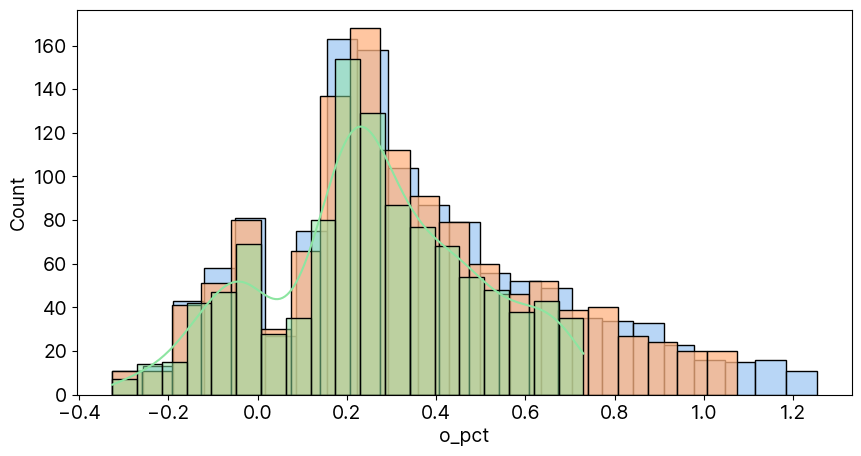

In [18]:
parameter = "o_pct"

s = df[parameter].describe(percentiles = percentiles)
plt.figure(figsize=(10,5))
print(s)
print(len(s))

print(f"Median: {statistics.median(s)}")

s = s.sort_values(ascending=True)

# Create plot
hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])], kde=True)

For now, we are only interested in positive values:

count    1120.000000
mean        0.498438
std         0.393432
min         0.002000
10%         0.147900
20%         0.202800
30%         0.242000
40%         0.294600
50%         0.372000
60%         0.457400
70%         0.595000
80%         0.759200
90%         1.038000
max         1.970000
Name: o_pct, dtype: float64
14
Median: 0.4254161403909903


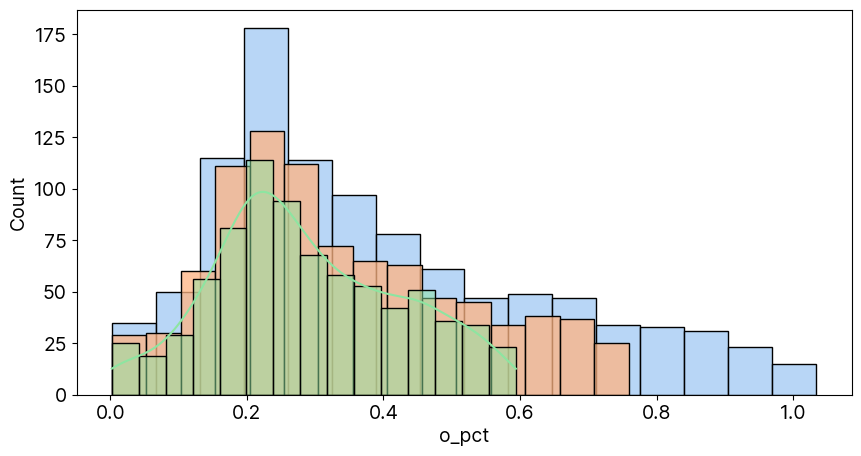

In [19]:
parameter = "o_pct"

lower_bound = 0
upper_bound = 2

s = df[parameter][(df[parameter] > lower_bound) & (df[parameter] < upper_bound)].describe(percentiles = percentiles)
plt.figure(figsize=(10,5))
print(s)
print(len(s))

print(f"Median: {statistics.median(s)}")

s = s.sort_values(ascending=True)

# Create plot
hp = sns.histplot(data = df[parameter][(df[parameter] > lower_bound) &(df[parameter] < s[11])])
# Zoom in
hp = sns.histplot(data = df[parameter][(df[parameter] > lower_bound) &(df[parameter] < s[10])])
# Zoom in some more
hp = sns.histplot(data = df[parameter][(df[parameter] > lower_bound) &(df[parameter] < s[9])], kde=True)

Now for 'morning_09:30:00_11:59:00_high_vs_low_pct':

count    1339.000000
mean       -0.239592
std         0.103178
min        -0.803845
10%        -0.376298
20%        -0.327813
30%        -0.283680
40%        -0.250000
50%        -0.219697
60%        -0.198745
70%        -0.175602
80%        -0.151804
90%        -0.125000
max        -0.027495
Name: morning_09:30:00_11:59:00_high_vs_low_pct, dtype: float64
14
Median: -0.2092209415823183


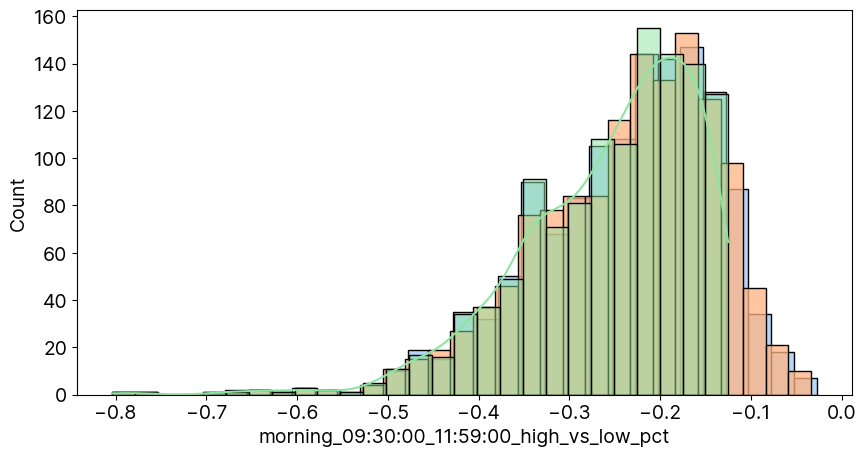

In [21]:
parameter = 'morning_09:30:00_11:59:00_high_vs_low_pct'

s = df[parameter].describe(percentiles = percentiles)
plt.figure(figsize=(10,5))
print(s)
print(len(s))

print(f"Median: {statistics.median(s)}")

s = s.sort_values(ascending=True)

# Create plot
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])], kde=True)

And now the pair plot. We know from above that 90% of all values are below 1 for 'o_pct' so let's limit the data in the chart to, e.g., less than 120%.

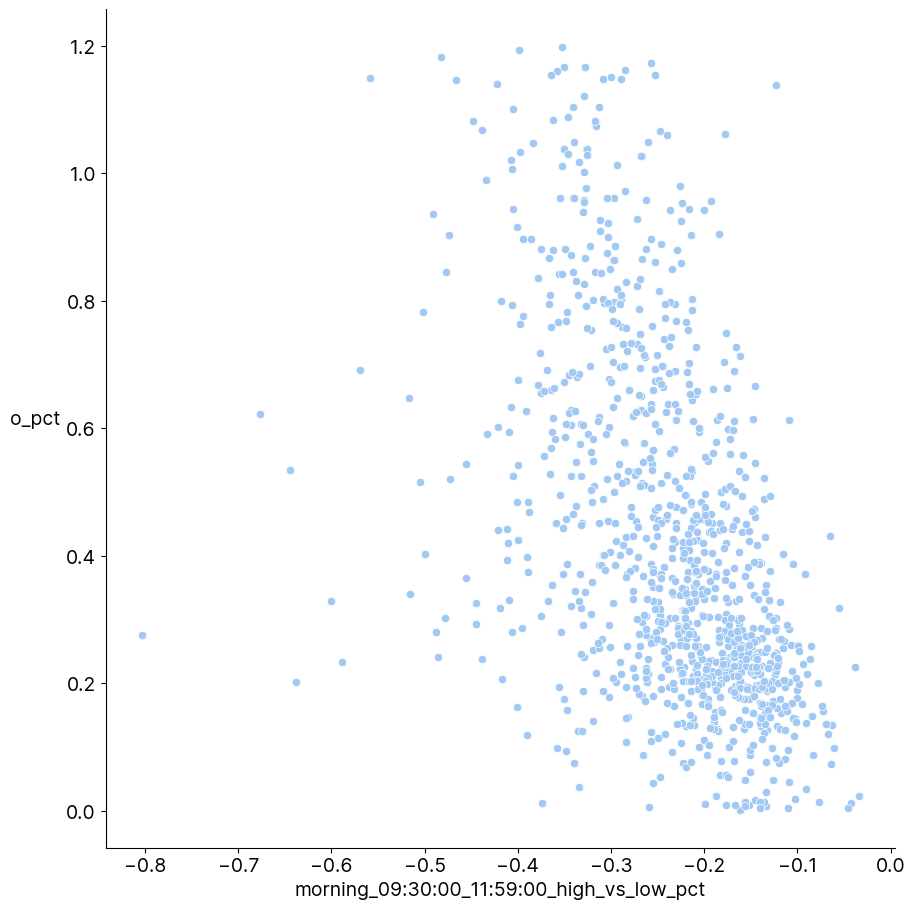

In [22]:
pp = sns.pairplot(data=df[(df['o_pct'] > 0) & (df['o_pct'] < 1.2)],
                  y_vars=['o_pct'],
                  x_vars=['morning_09:30:00_11:59:00_high_vs_low_pct'],
                  #x_vars=[(df["shs_float"] < 30)],
                 height=5)
pp.fig.set_size_inches(10,10)

# Rotate y-lables for better readability
for ax in pp.axes.flatten():
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

Let's also do a regression plot:

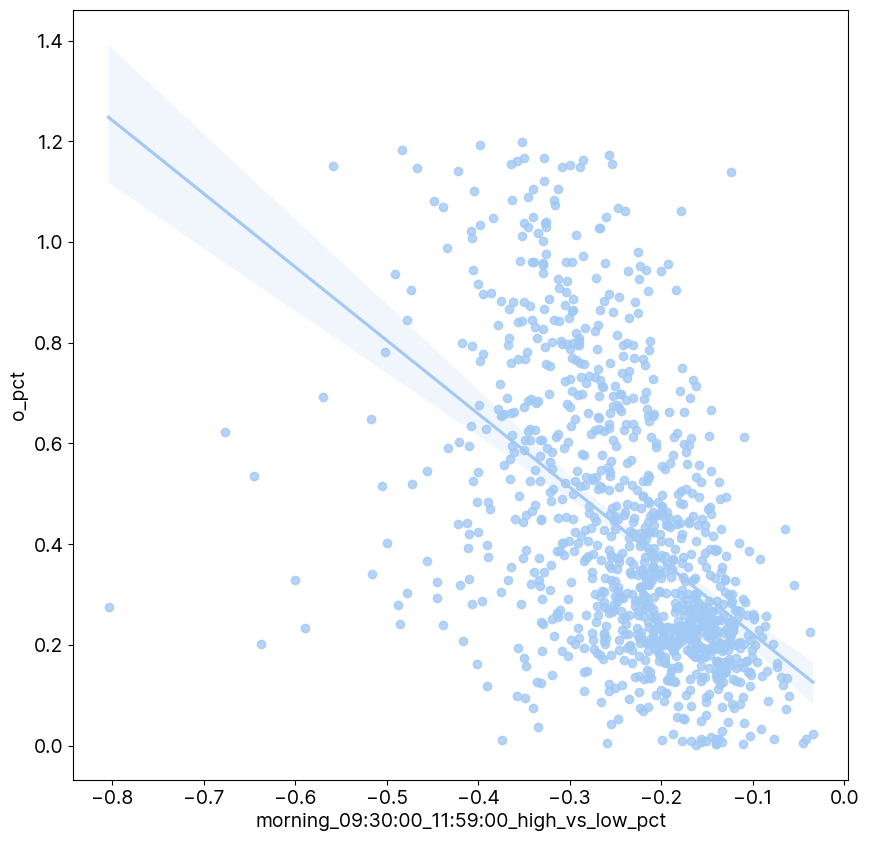

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
rp = sns.regplot(y="o_pct", x="morning_09:30:00_11:59:00_high_vs_low_pct", data=df[(df['o_pct'] > 0) & (df['o_pct'] < 1.2)], ax=ax)

We see a nice correlation between the gap up and how much the stock falls from its high to the low which makes sense. Based on the analysis above we can now refine our selection from 'source_df'. Let's add 'o_pct' as criterion, between 0 and 2.

In [24]:
select_df = source_df[(source_df['morning_09:30:00_11:59:00_high_t'] < source_df['morning_09:30:00_11:59:00_low_t']) & (df['o_pct'] > 0) & (df['o_pct'] < 2)] 

df = select_df.copy()

print(f"Number of rows in selection: {len(df.axes[0])}")

Number of rows in selection: 1120


It's a new df, so we have to calculate 'morning_09:30:00_11:59:00_high_vs_low_pct' again:

In [26]:
# Calculate percent change from high to low in a new df column
df['morning_09:30:00_11:59:00_high_vs_low_pct'] = df['morning_09:30:00_11:59:00_low'] / df['morning_09:30:00_11:59:00_high'] - 1

Display the data to check whether the selection is correct.

In [27]:
df[["date", "symbol", "morning_09:30:00_11:59:00_high_t", "morning_09:30:00_11:59:00_low_t", "morning_09:30:00_11:59:00_high_vs_low_pct", "morning_09:30:00_11:59:00_low", "morning_09:30:00_11:59:00_high"]]

,date,symbol,morning_09:30:00_11:59:00_high_t,morning_09:30:00_11:59:00_low_t,morning_09:30:00_11:59:00_high_vs_low_pct,morning_09:30:00_11:59:00_low,morning_09:30:00_11:59:00_high
5,2019-01-09,VTVT,09:46:00,10:46:00,-0.151515,2.80,3.3000
14,2019-01-17,LMFA,09:53:00,11:35:00,-0.322581,2.10,3.1000
16,2019-01-24,BLNK,09:37:00,09:56:00,-0.186441,2.40,2.9500
20,2019-01-29,AVCO,09:35:00,11:05:00,-0.246914,6.10,8.1000
21,2019-01-16,TBLT,09:34:00,11:19:00,-0.400000,3.33,5.5500
...,...,...,...,...,...,...,...
2273,2023-01-25,INPX,09:47:00,11:21:00,-0.251163,1.61,2.1500
2275,2023-01-26,BZFD,09:44:00,11:09:00,-0.209099,1.21,1.5299
2279,2023-01-26,BZFD,09:44:00,11:09:00,-0.209099,1.21,1.5299
2287,2023-02-02,TENX,09:31:00,11:48:00,-0.381395,2.66,4.3000


In [28]:
# We have to further narrow down our search because some 1-minute data has been adjusted for splits while eod data has not
# This results in some stocks seemingly shooting up, e.g., 8200%
# It makes sense to, e.g., leave out stocks gapping up more than 200% since we rarely see this
# df = df[(df["pattern"] == 'gap-up_short') &  (df["date"] > "2020-01-01") &  (df["o_pct"] < 2) & (df['shs_float'] < 50) ]

Write the dataframe to a CSV file.

In [29]:
df.to_csv("df.csv")

Let's check out some fundamental data.

count           1066
unique            18
top       Healthcare
freq             558
Name: sector, dtype: object


/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3865418329.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  hp.set_xticklabels(hp.get_xticklabels(), rotation=30)


[Text(0, 0, 'Healthcare'),
 Text(1, 0, 'Financial'),
 Text(2, 0, 'Consumer Cyclical'),
 Text(3, 0, 'n/a'),
 Text(4, 0, 'Industrials'),
 Text(5, 0, 'Basic Materials'),
 Text(6, 0, 'Technology'),
 Text(7, 0, 'Communication Services'),
 Text(8, 0, 'Conglomerates'),
 Text(9, 0, 'Energy'),
 Text(10, 0, 'Services'),
 Text(11, 0, 'Information Technology'),
 Text(12, 0, 'Consumer Goods'),
 Text(13, 0, 'Industrial Goods'),
 Text(14, 0, 'Consumer Discretionary'),
 Text(15, 0, 'Utilities'),
 Text(16, 0, 'Consumer Defensive'),
 Text(17, 0, 'Real Estate'),
 Text(18, 0, '')]

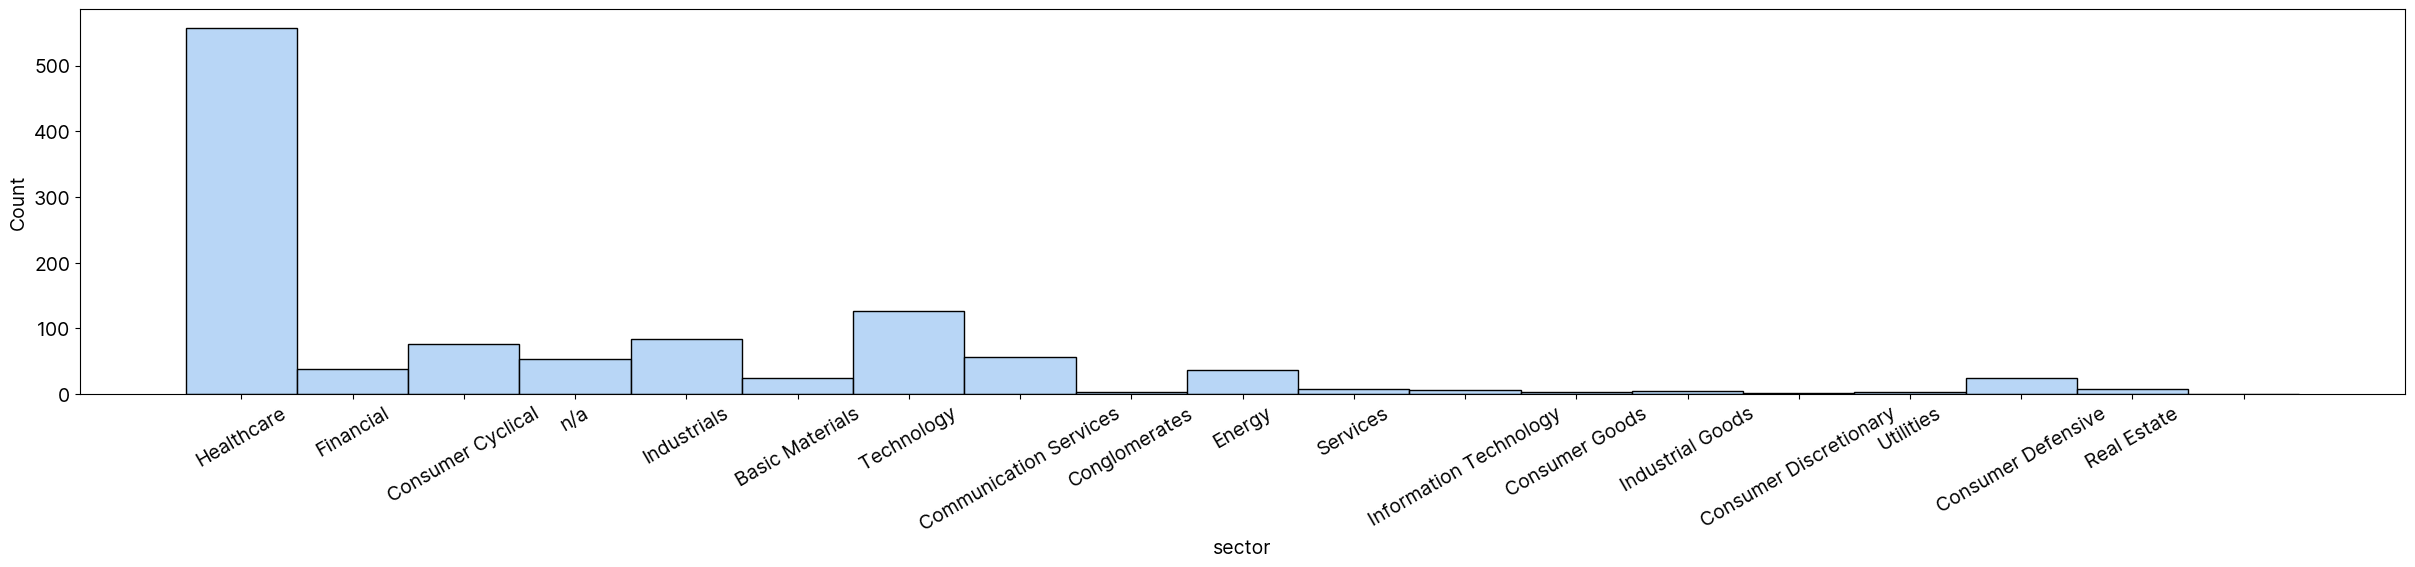

In [30]:
parameter = "sector"

s = df[parameter].describe(percentiles = percentiles)
print(s)

plt.figure(figsize=(30,5))
hp = sns.histplot(data = df[parameter].replace(np.nan, "n/a"))

# Rotate x-lables for better readability
hp.set_xticklabels(hp.get_xticklabels(), rotation=30)

count              1066
unique              123
top       Biotechnology
freq                374
Name: industry, dtype: object


/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/1550091918.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  hp.set_xticklabels(hp.get_xticklabels(), rotation=90)


A bit hard to read, but 'Biotechnology' is by far the most common industry.


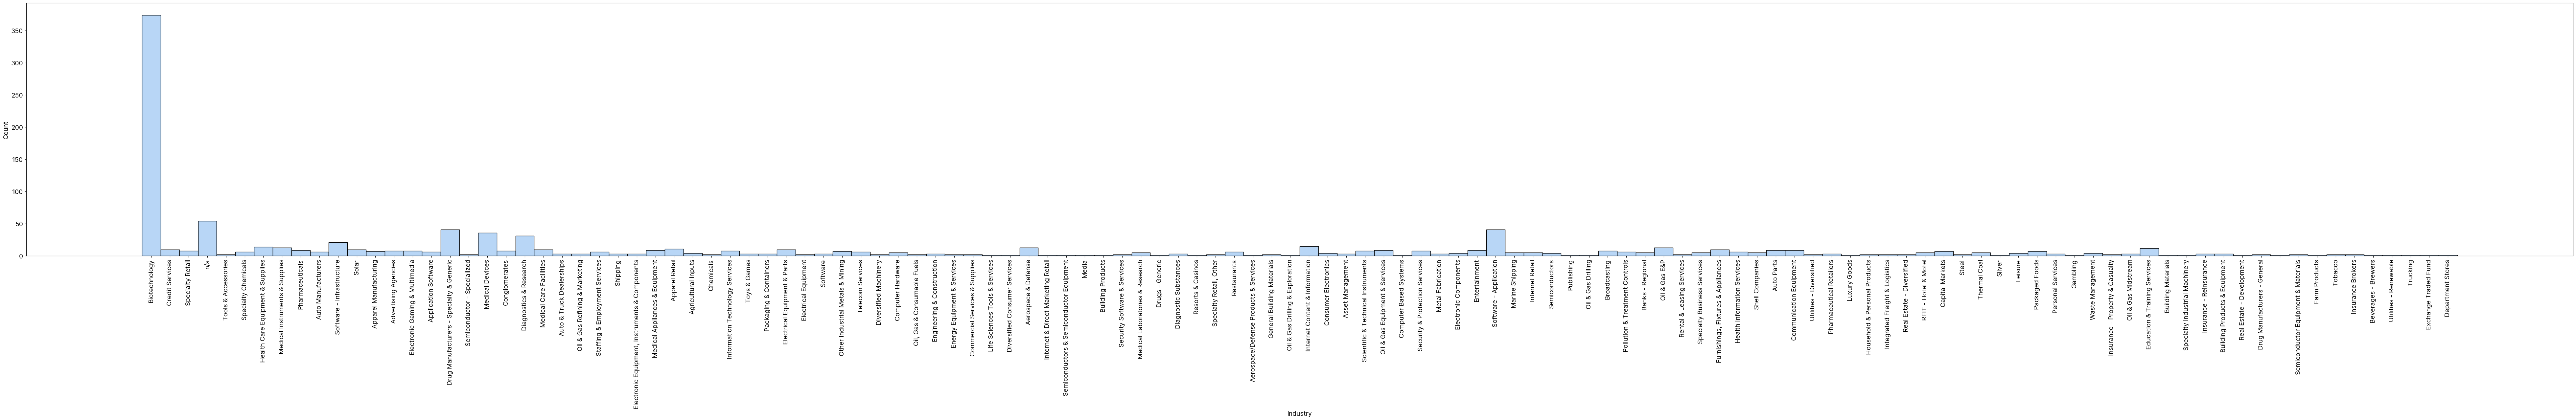

In [31]:
parameter = "industry"

s = df[parameter].describe(percentiles = percentiles)
print(s)
#df['shs_float'].hist()
plt.figure(figsize=(100,10))
hp = sns.histplot(data = df[parameter].replace(np.nan, "n/a"))

# Rotate x-lables for better readability
hp.set_xticklabels(hp.get_xticklabels(), rotation=90)

print(f"A bit hard to read, but 'Biotechnology' is by far the most common industry.")

In [32]:
# parameter = "pattern"

# s = df[parameter].describe(percentiles = percentiles)
# print(s)
# #df['shs_float'].hist()
# plt.figure(figsize=(100,10))
# hp = sns.histplot(data = df[parameter].replace(np.nan, "n/a"))

# # Rotate x-lables for better readability
# hp.set_xticklabels(hp.get_xticklabels(), rotation=90)

count    1114.000000
mean       31.764982
std       185.227449
min         0.000000
10%         1.883000
20%         3.120000
30%         4.530000
40%         6.712000
50%         9.560000
60%        13.926000
70%        20.273000
80%        35.102000
90%        62.573000
max      5380.000000
Name: shs_float, dtype: float64
Median: 17.099499999999995


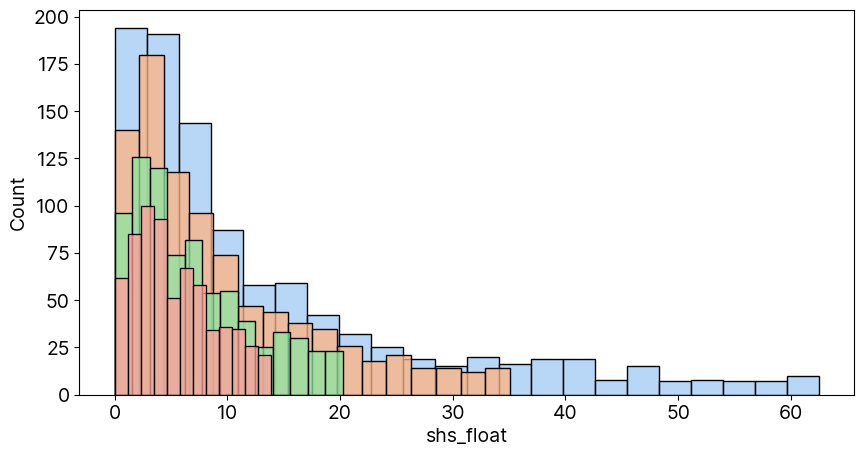

In [33]:
parameter = "shs_float"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])

count     1114.00000
mean       253.77268
std       1407.02815
min          0.00000
10%          9.96500
20%         16.45400
30%         25.42000
40%         37.62400
50%         55.21000
60%         71.63600
70%        104.93600
80%        151.56000
90%        330.33300
max      29380.00000
Name: mkt_cap, dtype: float64
Median: 88.28599999999999


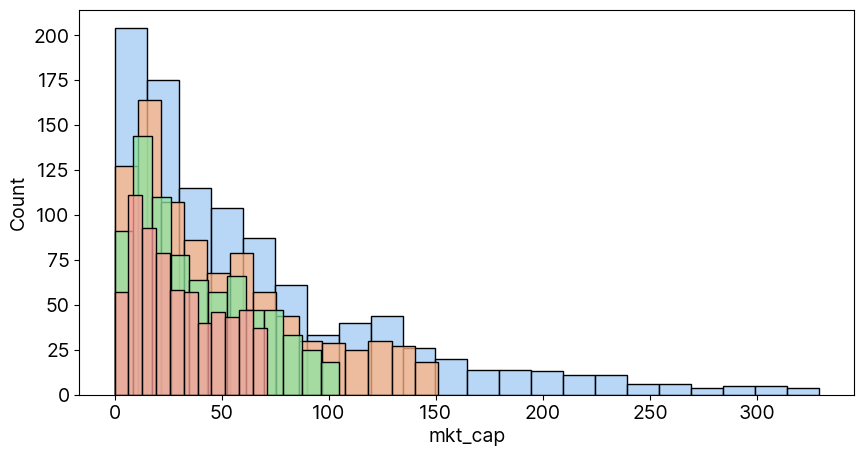

In [34]:
parameter = "mkt_cap"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])

count    1118.000000
mean        0.927809
std         2.028894
min        -0.035000
10%         0.282700
20%         0.383000
30%         0.467100
40%         0.566800
50%         0.675000
60%         0.807400
70%         0.972800
80%         1.232600
90%         1.679100
max        57.204000
Name: premkt_04:00:00_09:29:00_high_vs_c-1_pct, dtype: float64
Median: 0.8676042933810375
How high (in percent vs the previous session close) do they go pre-market? Since we did not select a pattern the spike at the 0.0 mark is probably due to parabolic shorts that open near previous close and then spike.


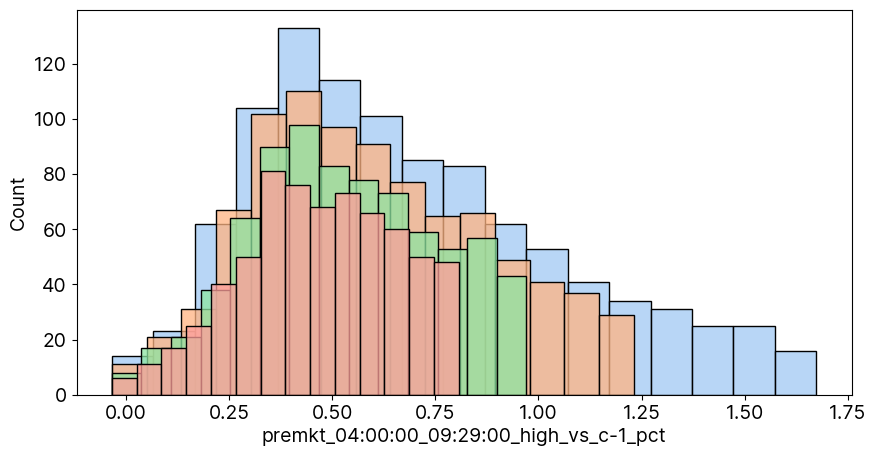

In [35]:
parameter = "premkt_04:00:00_09:29:00_high_vs_c-1_pct"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])

print("How high (in percent vs the previous session close) do they go pre-market? \
Since we did not select a pattern the spike at the 0.0 mark is probably due to \
parabolic shorts that open near previous close and then spike.")

count    1.120000e+03
mean     7.320801e+06
std      1.208760e+07
min      0.000000e+00
10%      4.929800e+05
20%      1.152876e+06
30%      1.850614e+06
40%      2.694394e+06
50%      3.902856e+06
60%      5.322914e+06
70%      7.614843e+06
80%      1.146540e+07
90%      1.800609e+07
max      2.599724e+08
Name: premkt_04:00:00_09:29:00_volume, dtype: float64
Median: 4612884.75


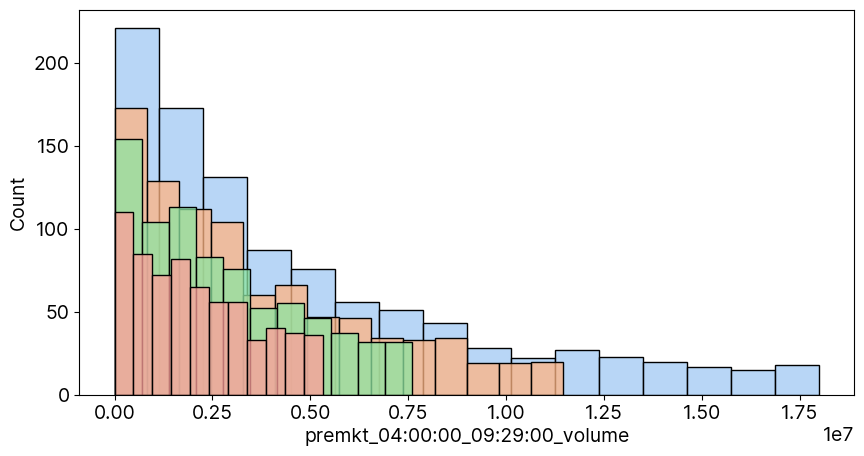

In [36]:
parameter = "premkt_04:00:00_09:29:00_volume"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])


count    1120.000000
mean        6.930957
std        15.893795
min         1.090000
10%         2.224500
20%         2.768000
30%         3.220000
40%         3.880000
50%         4.625000
60%         5.590000
70%         6.800000
80%         8.390000
90%        11.458000
max       379.710000
Name: o, dtype: float64
14
Median: 6.195


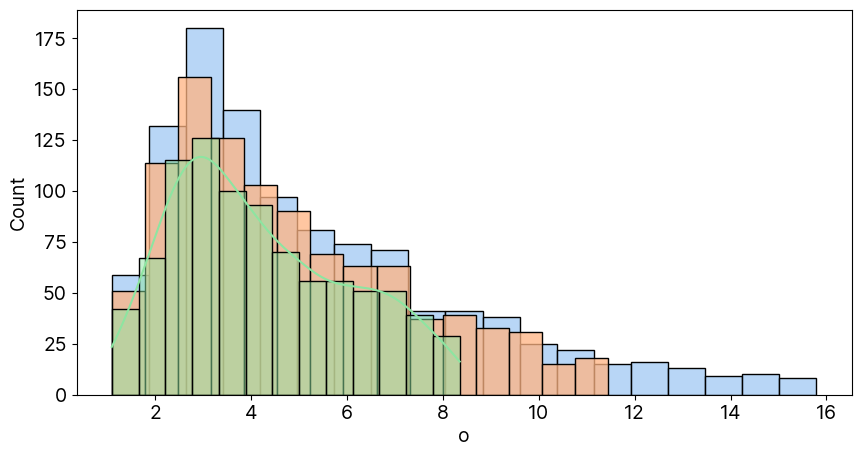

In [37]:
parameter = "o"

s = df[parameter].describe(percentiles = percentiles)
plt.figure(figsize=(10,5))
print(s)
print(len(s))

print(f"Median: {statistics.median(s)}")

s = s.sort_values(ascending=True)

# Create plot
hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])], kde=True)

count    1114.000000
mean             inf
std              NaN
min         0.000000
10%         0.031660
20%         0.085664
30%         0.155594
40%         0.260043
50%         0.379825
60%         0.597059
70%         0.937785
80%         1.459077
90%         2.613933
max              inf
Name: premkt_04:00:00_09:29:00_volume_vs_shs_float, dtype: float64
Median: 0.20781867267967222


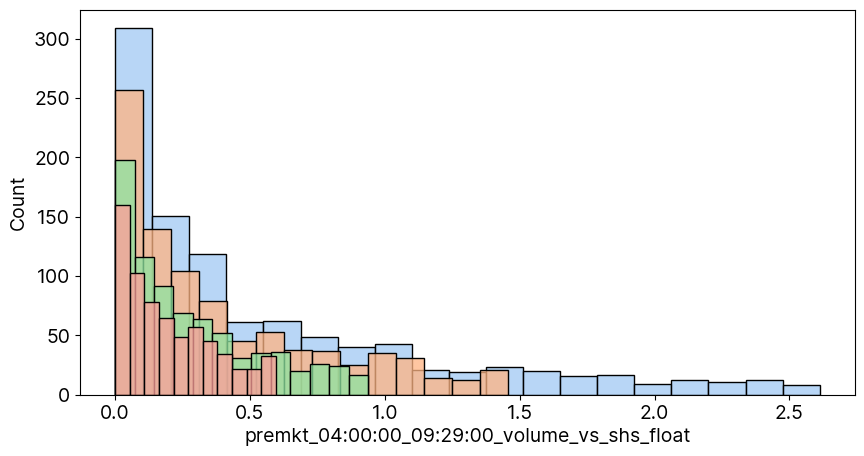

In [38]:
parameter = "premkt_04:00:00_09:29:00_volume_vs_shs_float"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])

Stocks that gap up a lot are often manipulated and start going up close to the open, not at, e.g., 6:30 am or 7 am. Not a lot of float rotation going on there. It's desirable to manipulate the stock higher with as little funds/volume as possible.

When do highs and lows occur?

/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3379018753.py:10: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  s.sort_values(ascending=True, inplace=True)
/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3379018753.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)


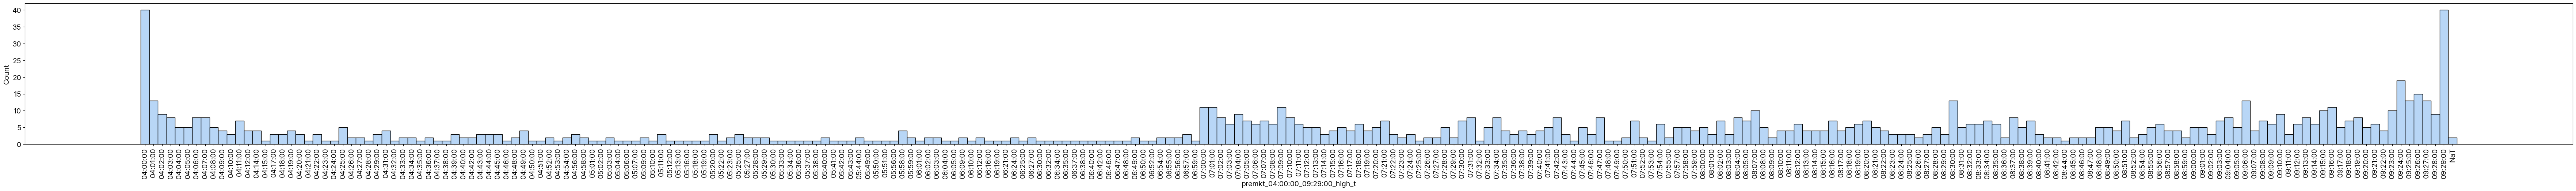

In [39]:
parameter = "premkt_04:00:00_09:29:00_high_t"

s = df[parameter]

# Tried to have only the time - otherwise pandas
# appends 1900-01-01 in front - but this does 
# not work for seaborn plotting
# https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime
s = pd.to_datetime(s, format='%H:%M:%S').dt.time
s.sort_values(ascending=True, inplace=True)

#print(s)

# Convert to string otherwise histogram does not work
s = s.astype(str)

plt.figure(figsize=(90,5))
hp = sns.histplot(data = s)

# Rotate x-lables for better readability
hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)

Spikes at 4 am and 9:29 make sense. Also visible is the increase at 7 am since that's when many brokers allow clients to trade pre-market.

/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3620682574.py:10: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  s.sort_values(ascending=True, inplace=True)
/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3620682574.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)


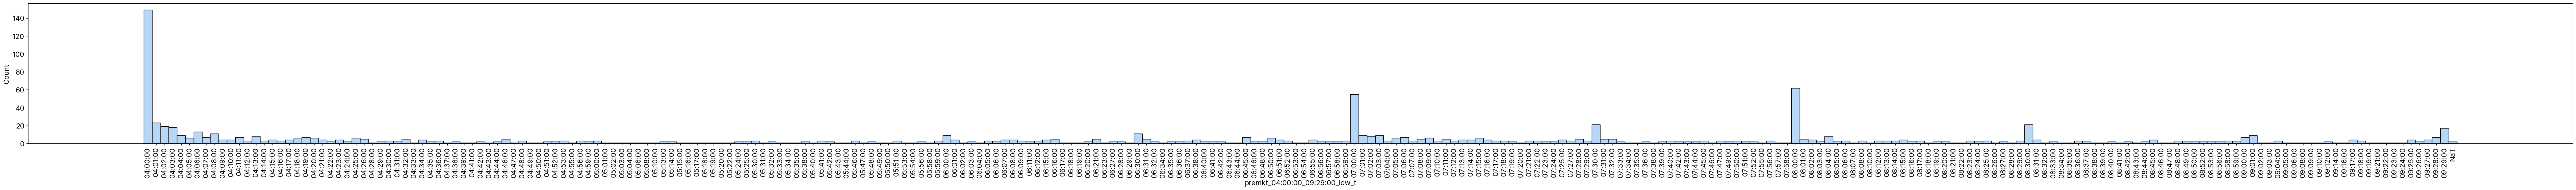

In [40]:
parameter = "premkt_04:00:00_09:29:00_low_t"

s = df[parameter]

# Tried to have only the time - otherwise pandas
# appends 1900-01-01 in front - but this does 
# not work for seaborn plotting
# https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime
s = pd.to_datetime(s, format='%H:%M:%S').dt.time
s.sort_values(ascending=True, inplace=True)

#print(s)

# Convert to string otherwise histogram does not work
s = s.astype(str)

plt.figure(figsize=(90,5))
hp = sns.histplot(data = s)

# Rotate x-lables for better readability
hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)

/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/436293379.py:10: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  s.sort_values(ascending=True, inplace=True)
/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/436293379.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)


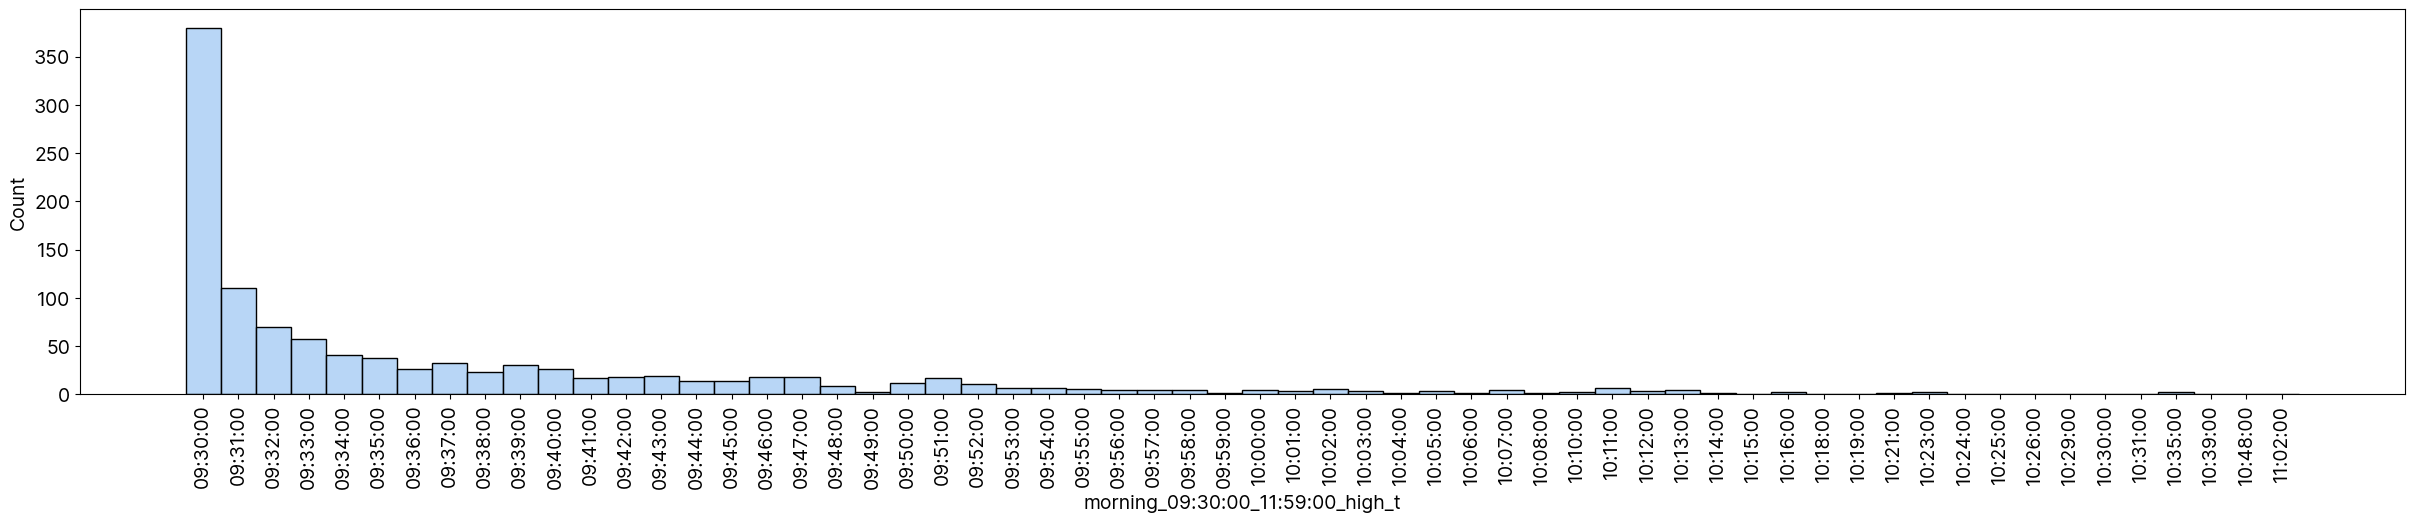

In [41]:
parameter = "morning_09:30:00_11:59:00_high_t"

s = df[parameter]

# Tried to have only the time - otherwise pandas
# appends 1900-01-01 in front - but this does 
# not work for seaborn plotting
# https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime
s = pd.to_datetime(s, format='%H:%M:%S').dt.time
s.sort_values(ascending=True, inplace=True)

#print(s)

# Convert to string otherwise histogram does not work
s = s.astype(str)

plt.figure(figsize=(30,5))
hp = sns.histplot(data = s)

# Rotate x-lables for better readability
hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)

/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3252010679.py:10: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  s.sort_values(ascending=True, inplace=True)
/var/folders/s9/wdvhc0790lbd65fxspb0_45m0000gn/T/ipykernel_86032/3252010679.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)


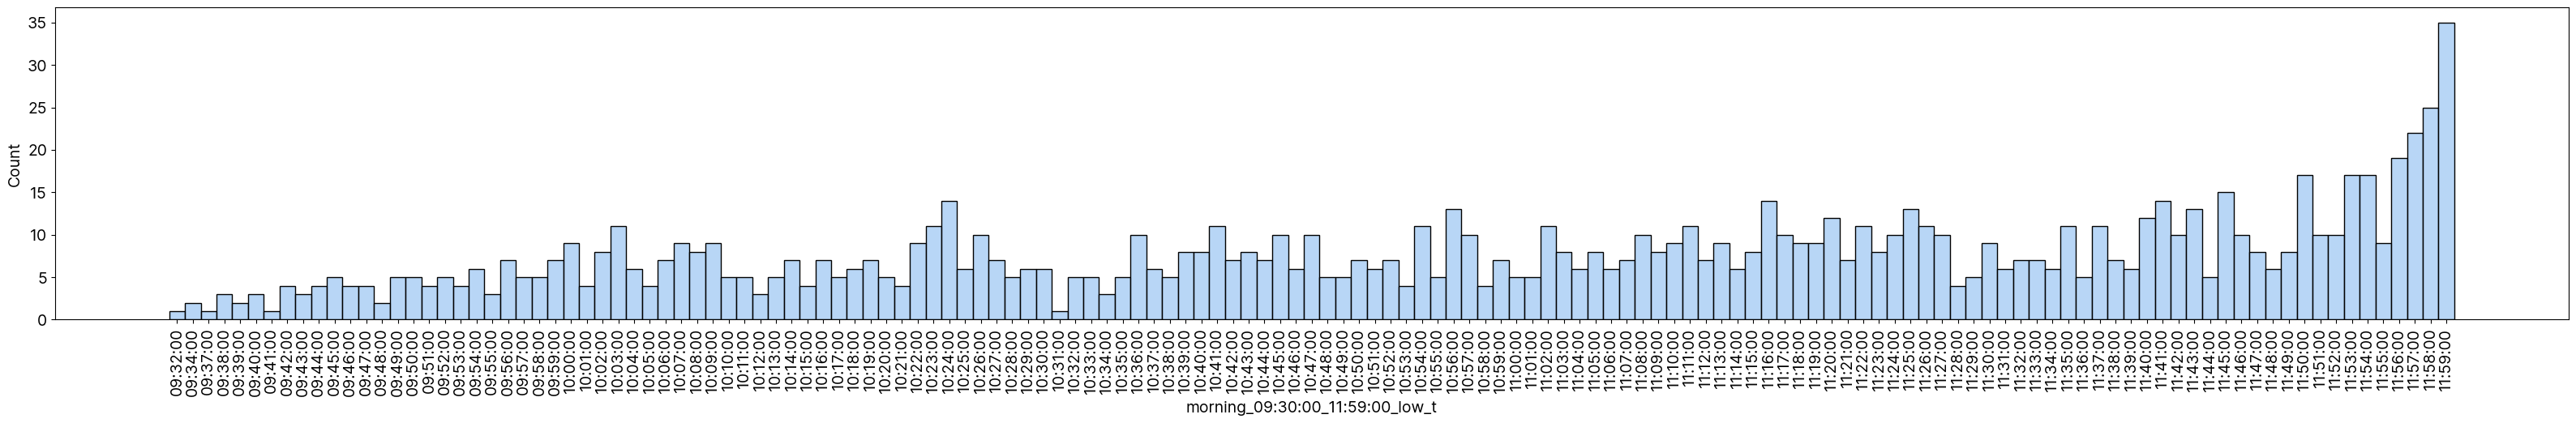

In [42]:
parameter = "morning_09:30:00_11:59:00_low_t"

s = df[parameter]

# Tried to have only the time - otherwise pandas
# appends 1900-01-01 in front - but this does 
# not work for seaborn plotting
# https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime
s = pd.to_datetime(s, format='%H:%M:%S').dt.time
s.sort_values(ascending=True, inplace=True)

#print(s)

# Convert to string otherwise histogram does not work
s = s.astype(str)

plt.figure(figsize=(40,5))
hp = sns.histplot(data = s)

# Rotate x-lables for better readability
hp = hp.set_xticklabels(hp.get_xticklabels(), rotation=90)

count    1120.000000
mean        0.148388
std         1.080062
min        -0.114000
10%         0.006000
20%         0.018000
30%         0.030700
40%         0.045000
50%         0.061500
60%         0.079400
70%         0.107000
80%         0.159000
90%         0.223000
max        27.455000
Name: morning_09:30:00_11:59:00_high_vs_o_pct, dtype: float64
Median: 0.09319999999999999


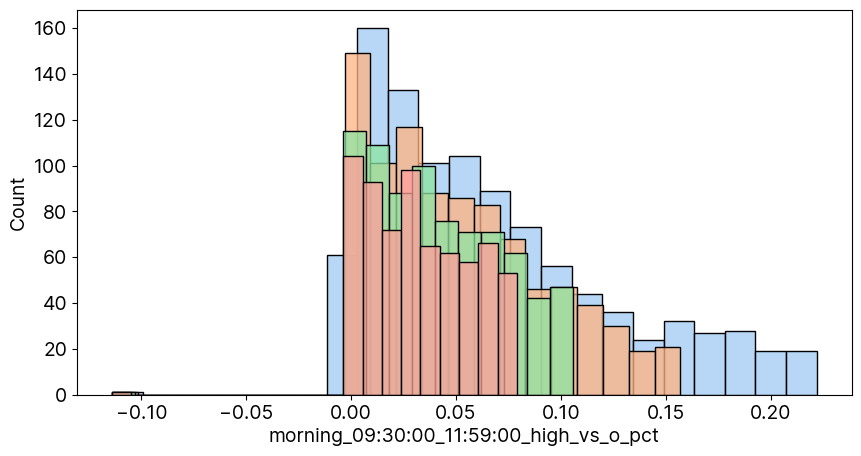

In [43]:
parameter = "morning_09:30:00_11:59:00_high_vs_o_pct"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])

count    1120.000000
mean       -0.146460
std         0.650654
min        -0.662000
10%        -0.298100
20%        -0.246000
30%        -0.213300
40%        -0.190000
50%        -0.166500
60%        -0.144000
70%        -0.122700
80%        -0.101000
90%        -0.075000
max        15.167000
Name: morning_09:30:00_11:59:00_low_vs_o_pct, dtype: float64
Median: -0.1452299107142857


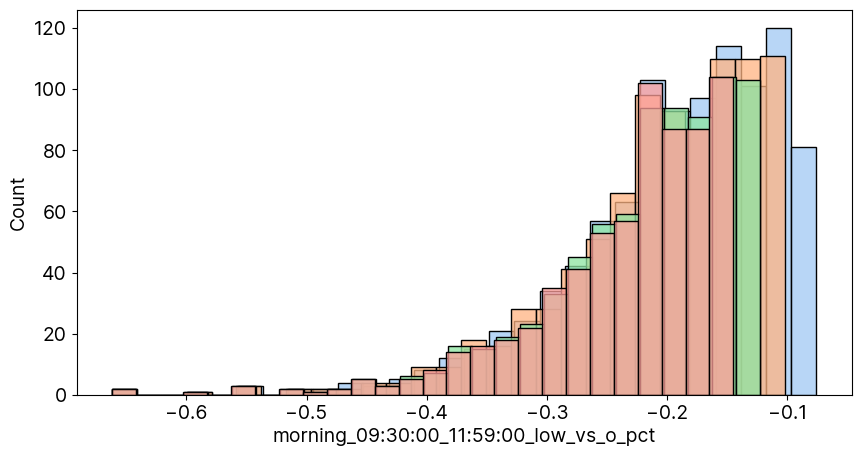

In [44]:
parameter = "morning_09:30:00_11:59:00_low_vs_o_pct"

s = df[parameter].describe(percentiles = percentiles)
print(s)

print(f"Median: {statistics.median(s)}")

plt.figure(figsize=(10,5))
hp = sns.histplot(data = df[parameter][(df[parameter] < s[12])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[11])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[10])])

hp = sns.histplot(data = df[parameter][(df[parameter] < s[9])])

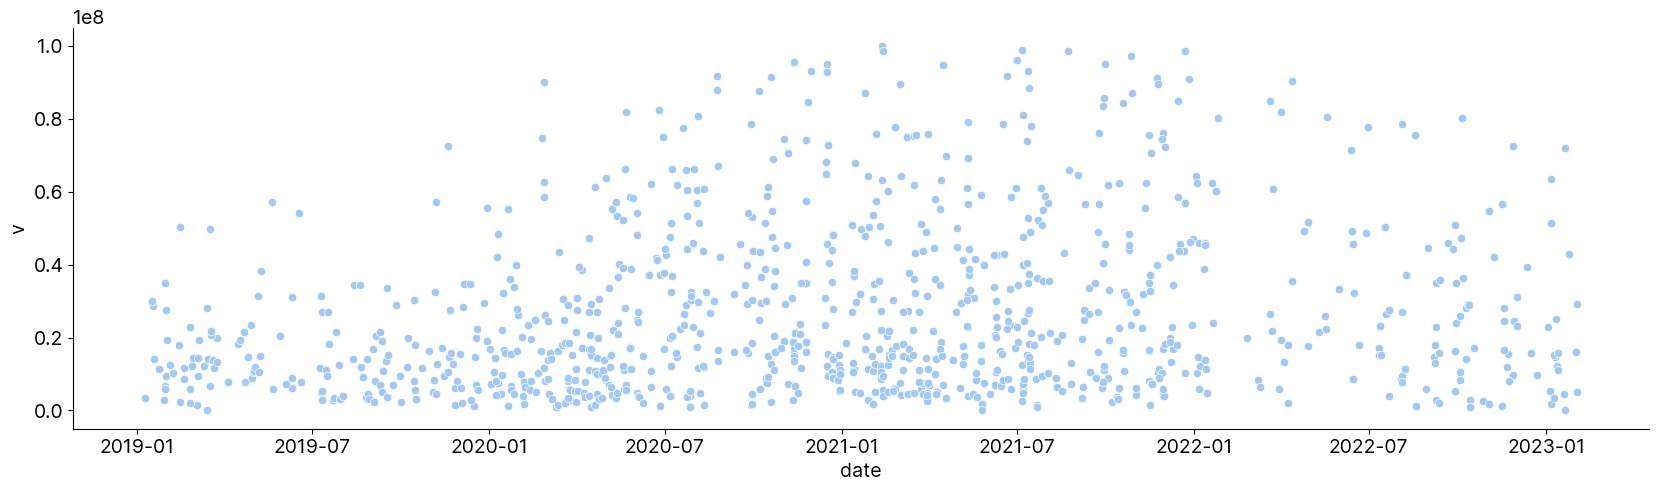

In [45]:
# premkt_04:00:00_09:29:00_volume_mean_over_last_15_candles
# data=df[(df["morning_09:30:00_11:59:00_high_vs_c-1_pct"] < 5)
pp = sns.pairplot(data=df[(df['v'] < 100000000)],
                  x_vars=['date'],
                  y_vars=['v'],
                 height=5)
pp.fig.set_size_inches(20,5)

More general: session volume did increase, starting together with the bull market starting in March 2020. Looks like it's going down again. The sample size during 2022 is smaller, for various reasons I was unable to track stocks as disciplined as in earlier years.

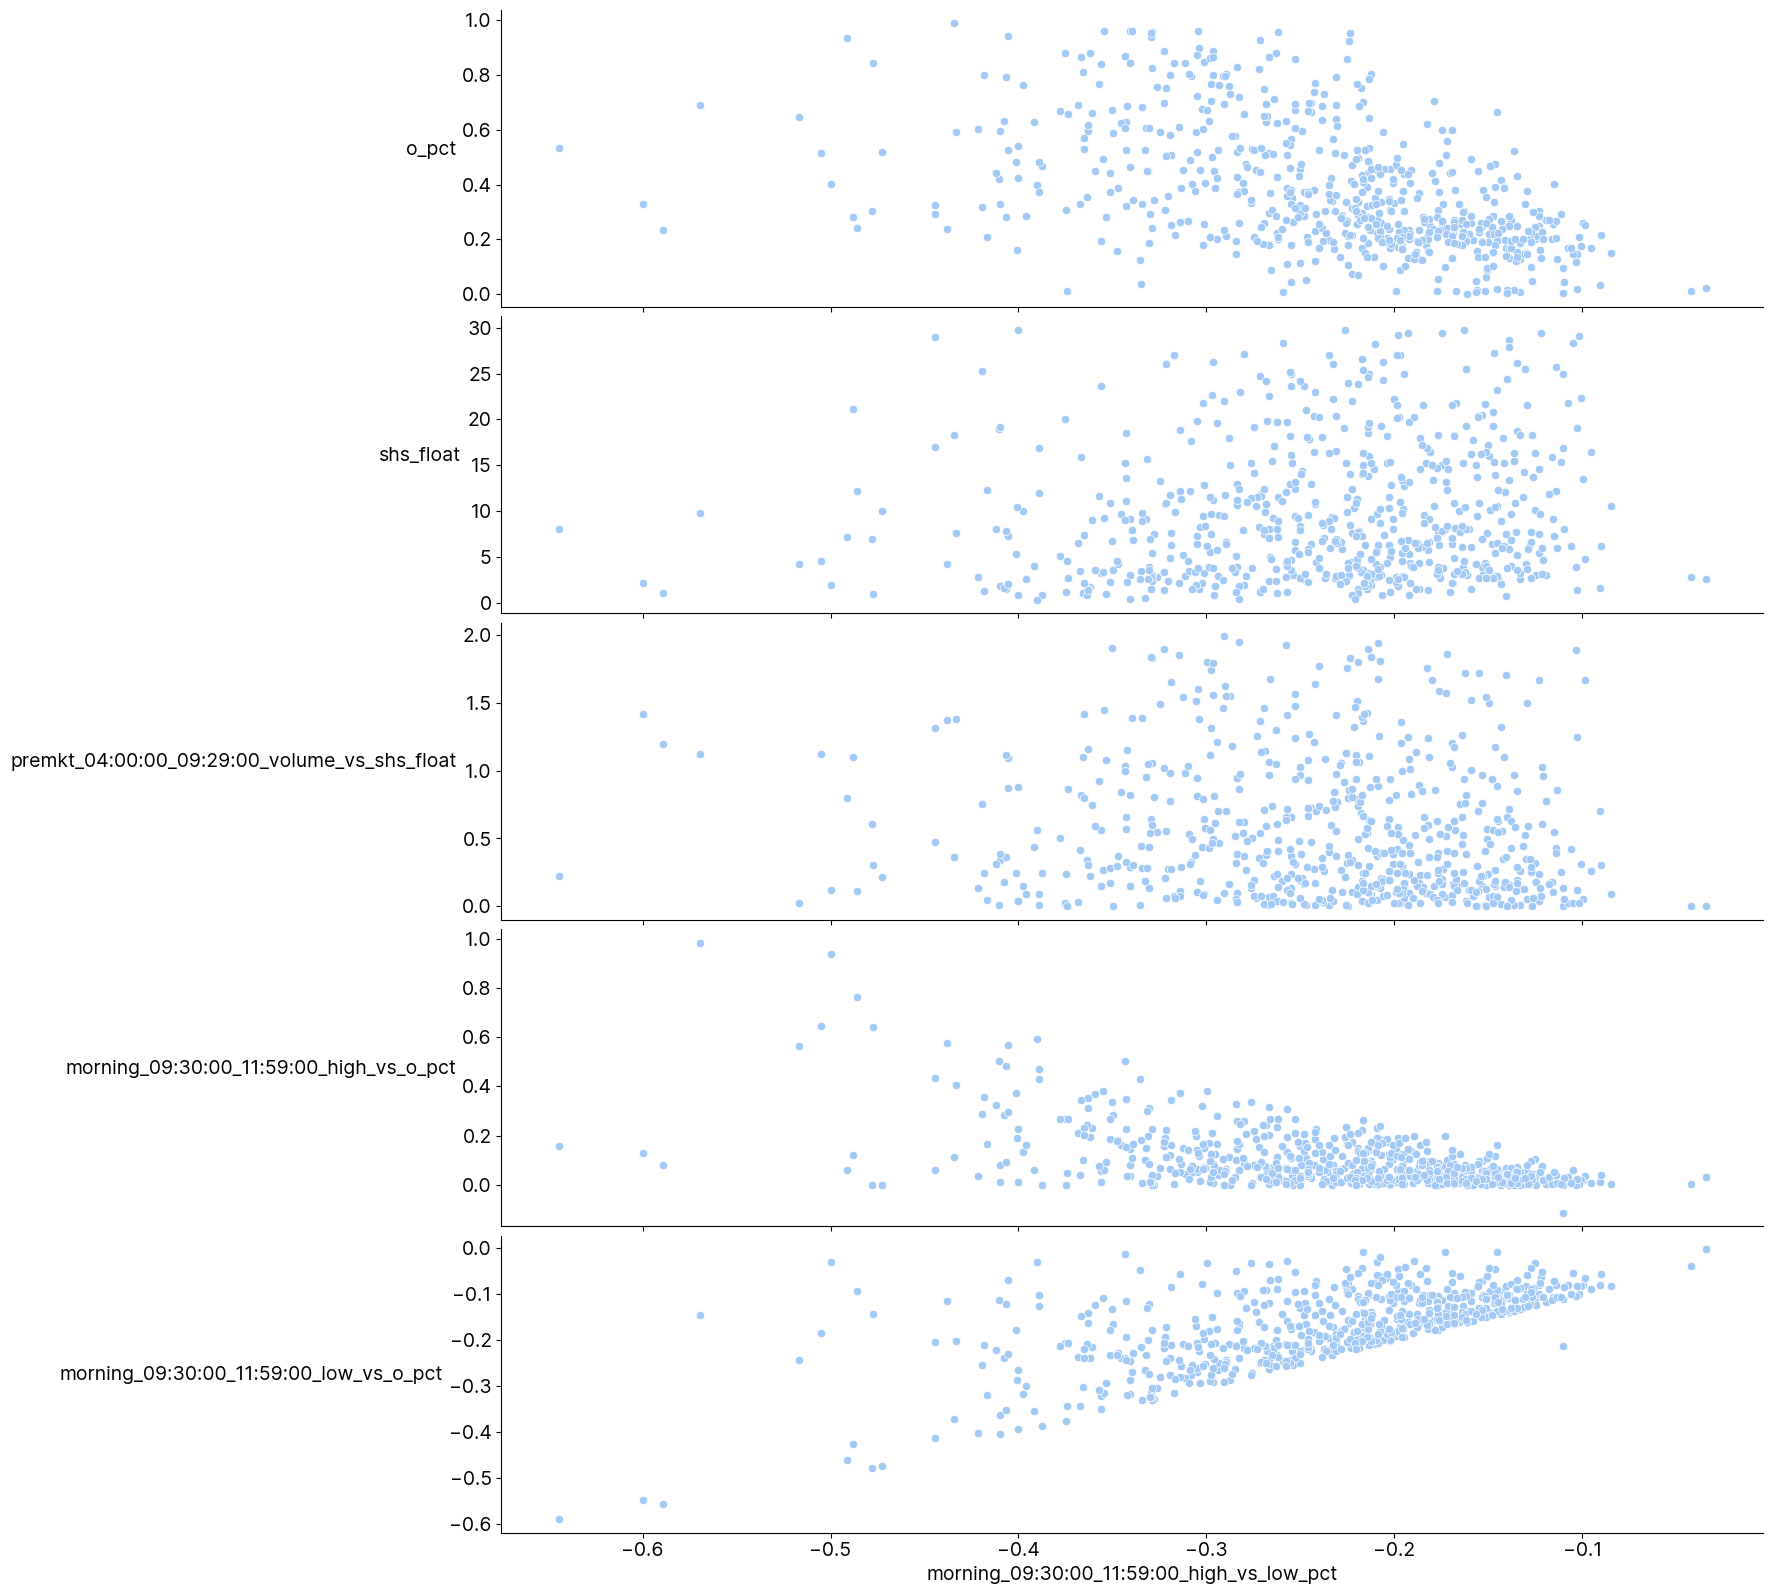

In [46]:
pp = sns.pairplot(data=df[(df["morning_09:30:00_11:59:00_high_vs_c-1_pct"] < 5) & (df['morning_09:30:00_11:59:00_low_vs_o_pct'] < 0) & (df['premkt_04:00:00_09:29:00_volume_vs_shs_float'] < 2) & (df['o_pct'] < 1) & (df['shs_float'] < 30)],
                  y_vars=['o_pct', 'shs_float', 'premkt_04:00:00_09:29:00_volume_vs_shs_float', 'morning_09:30:00_11:59:00_high_vs_o_pct', 'morning_09:30:00_11:59:00_low_vs_o_pct'],
                  x_vars=['morning_09:30:00_11:59:00_high_vs_low_pct'],
                  #x_vars=[(df["shs_float"] < 30)],
                 height=5)
pp.fig.set_size_inches(16,16)

# Rotate y-lables for better readability
for ax in pp.axes.flatten():
    # rotate x axis labels
    #ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')